# Jupyter notebook for debugging

In [24]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5s_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create


                 from  n    params  module                                  arguments                     
  0                -1  1     21120  models.common.MultiStreamConv           [3, 96, 6, 2, 2]              
  1                -1  1    332544  models.common.MultiStreamConv           [96, 192, 3, 2]               


  2                -1  4    889344  models.common.MultiStreamC3             [192, 192, 4]                 
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1    148224  models.common.Conv                      [384, 384, 1, 1]              
  5                -1  1   1327872  models.common.Conv                      [384, 384, 3, 2]              
  6                -1  8   3251712  models.common.C3                        [384, 384, 8]                 
  7                -1  1   2655744  models.common.Conv                      [384, 768, 3, 2]              
  8                -1 12  18895872  models.common.C3                        [768, 768, 12]                
  9                -1  1  10619904  models.common.Conv                      [768, 1536, 3, 2]             
 10                -1  4  28329984  models.common.C3                        [1536, 1536, 4]               
 11                -1  1   5902848  m

## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

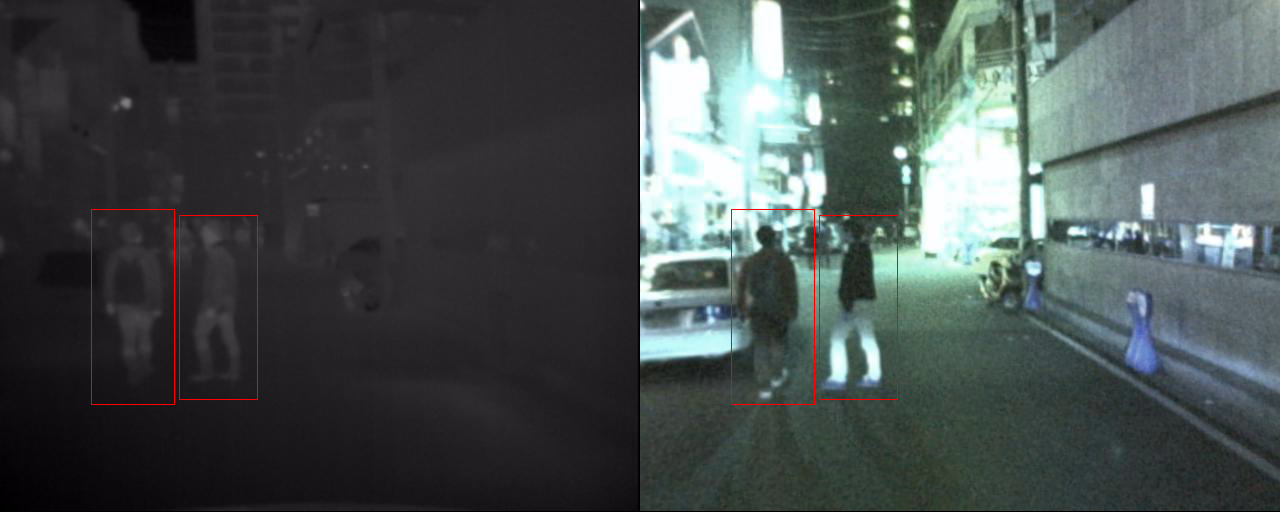

In [26]:
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy
import yaml

# 필요한 유틸리티 함수 임포트
from utils.dataloaders import create_dataloader, LoadRGBTImagesAndLabels
from utils.general import check_img_size, colorstr, xywh2xyxy

# --- 1. 데이터셋 및 하이퍼파라미터 로드 ---
print("데이터셋과 하이퍼파라미터를 로드합니다...")

with open('/home/byounggun/AUE8088/data/kaist-rgbt.yaml', 'r') as f:
    data_dict = yaml.safe_load(f)

with open('/home/byounggun/AUE8088/data/hyps/hyp.no-augmentation.yaml', 'r') as f:
    hyp = yaml.safe_load(f)

gs = 32  # grid size
imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
if isinstance(train_path, list):
    train_path = train_path[0]

dataset_root = data_dict.get("path", "")
import os
if not os.path.isabs(train_path):
    train_path_full = os.path.join(dataset_root, train_path)
else:
    train_path_full = train_path

print(f"train_path: {train_path_full}")
print(f"train_path exists? {os.path.exists(train_path_full)}")

imgsz = check_img_size(imgsz, gs, floor=gs * 2)

_, dataset = create_dataloader(
    train_path_full,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=True,
    cache=None,
    rect=False,
    rank=-1,
    workers=1,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,
    seed=seed,
    rgbt_input=True,
)

print("데이터셋 로드 완료.")
print(f"사용된 Hyperparameter (hyp): {hyp.get('mosaic', 'N/A')}")


# --- 2. 시각화를 위한 데이터 준비 ---

# 임의의 프레임 선택
frame_to_visualize = 1

# 원본 데이터셋 복사본 생성 (모자이크 및 증강 비활성화)
dataset_orig = copy.deepcopy(dataset)
dataset_orig.mosaic = False
dataset_orig.augment = False

# 모자이크 증강이 적용된 데이터셋 복사본 생성
dataset_mosaic = copy.deepcopy(dataset)
dataset_mosaic.mosaic = True  # 시각화를 위해 모자이크 증강 강제 적용

# 두 이미지 세트 로드
print(f"\n프레임 {frame_to_visualize}의 모자이크 데이터와 원본 데이터를 로드합니다...")
imgs_mosaic, targets_mosaic, paths_mosaic, _, _ = LoadRGBTImagesAndLabels.collate_fn([dataset_mosaic[frame_to_visualize]])
imgs_orig, targets_orig, paths_orig, _, _ = LoadRGBTImagesAndLabels.collate_fn([dataset_orig[frame_to_visualize]])
print("데이터 로드 완료.")

idx = 0

# 모자이크 증강된 이미지
img_lwir_mosaic = imgs_mosaic[0][idx].numpy().transpose((1, 2, 0))
img_vis_mosaic = imgs_mosaic[1][idx].numpy().transpose((1, 2, 0))

# 원본 이미지
img_lwir_orig = imgs_orig[0][idx].numpy().transpose((1, 2, 0))
img_vis_orig = imgs_orig[1][idx].numpy().transpose((1, 2, 0))


# --- 3. 바운딩 박스 시각화 ---

def draw_boxes(img, targets, idx, w, h):
    img_copy = img.copy().astype(np.float32) # 타입 변경
    colors = {
        0: (255, 0, 0),    # 빨간색
        1: (0, 255, 0),    # 녹색
        2: (0, 0, 255),    # 파란색
        3: (255, 0, 255),  # 마젠타
    }
    
    labels = targets.numpy()
    if len(labels):
        labels = labels[labels[:, 0] == idx, 1:]
        
        # 정규화된 xywh를 픽셀 xywh로 변환
        labels = np.array(labels, dtype=np.float32)
        labels[:, (1, 3)] *= w
        labels[:, (2, 4)] *= h
        
        cls = labels[:, 0]
        
        # xywh → xyxy 변환
        xyxy = xywh2xyxy(labels[:, 1:5]).astype(np.int16)
        
        img_copy = np.ascontiguousarray(img_copy)
        
        for c, bb in zip(cls, xyxy):
            color = colors.get(int(c), (255, 255, 255)) # 없는 클래스는 흰색으로
            cv2.rectangle(img_copy, bb[:2], bb[2:], color, 2)
            cv2.putText(img_copy, f'cls:{int(c)}', (bb[0], bb[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_copy

# 바운딩 박스 그리기
h_mosaic, w_mosaic = img_vis_mosaic.shape[:2]
h_orig, w_orig = img_vis_orig.shape[:2]

img_lwir_mosaic_box = draw_boxes(img_lwir_mosaic, targets_mosaic, idx, w_mosaic, h_mosaic)
img_vis_mosaic_box = draw_boxes(img_vis_mosaic, targets_mosaic, idx, w_mosaic, h_mosaic)
img_lwir_orig_box = draw_boxes(img_lwir_orig, targets_orig, idx, w_orig, h_orig)
img_vis_orig_box = draw_boxes(img_vis_orig, targets_orig, idx, w_orig, h_orig)

# Matplotlib 표시를 위해 uint8로 변환
img_lwir_mosaic_box = img_lwir_mosaic_box.astype(np.uint8)
img_vis_mosaic_box = img_vis_mosaic_box.astype(np.uint8)
img_lwir_orig_box = img_lwir_orig_box.astype(np.uint8)
img_vis_orig_box = img_vis_orig_box.astype(np.uint8)


# --- 4. 최종 결과 표시 ---
print("결과를 시각화합니다...")
plt.figure(figsize=(16, 12))

# 모자이크 이미지 표시
plt.subplot(2, 2, 1)
plt.title("Mosaic LWIR (Thermal)")
plt.imshow(cv2.cvtColor(img_lwir_mosaic_box, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Mosaic VIS (RGB)")
plt.imshow(cv2.cvtColor(img_vis_mosaic_box, cv2.COLOR_BGR2RGB))
plt.axis('off')

# # 원본 이미지 표시
# plt.subplot(2, 2, 3)
# plt.title("Original LWIR (Thermal)")
# plt.imshow(cv2.cvtColor(img_lwir_orig_box, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.subplot(2, 2, 4)
# plt.title("Original VIS (RGB)")
# plt.imshow(cv2.cvtColor(img_vis_orig_box, cv2.COLOR_BGR2RGB))
# plt.axis('off')

plt.suptitle("Mosaic Augmentation vs Original Images")
plt.tight_layout()
plt.show()

# 경로 출력
print(f"\nOriginal path: {paths_orig[idx]}")

데이터셋과 하이퍼파라미터를 로드합니다...
train_path: /home/byounggun/AUE8088/datasets/kaist-rgbt/train-all-04.txt
train_path exists? True


train: Scanning /home/byounggun/AUE8088/datasets/kaist-rgbt/train-all-04.cache... 12538 images, 7009 backgrounds, 0 corrupt: 100%|██████████| 12538/12538 [00:00<?, ?it/s]


데이터셋 로드 완료.
사용된 Hyperparameter (hyp): 1.0

프레임 1의 모자이크 데이터와 원본 데이터를 로드합니다...
데이터 로드 완료.

Original path: datasets/kaist-rgbt/train/images/{}/set00_V000_I00007.jpg


--- 이미지 데이터 검사 (img_vis_mosaic) ---
Data Type: uint8
Max Value: 255
Min Value: 0
------------------------------------
Mosaic LWIR shape: (640, 640, 3)
Mosaic VIS shape: (640, 640, 3)
Original LWIR shape: (640, 640, 3)
Original VIS shape: (640, 640, 3)
Mosaic path: datasets/kaist-rgbt/train/images/{}/set00_V000_I00007.jpg
Original path: datasets/kaist-rgbt/train/images/{}/set00_V000_I00007.jpg


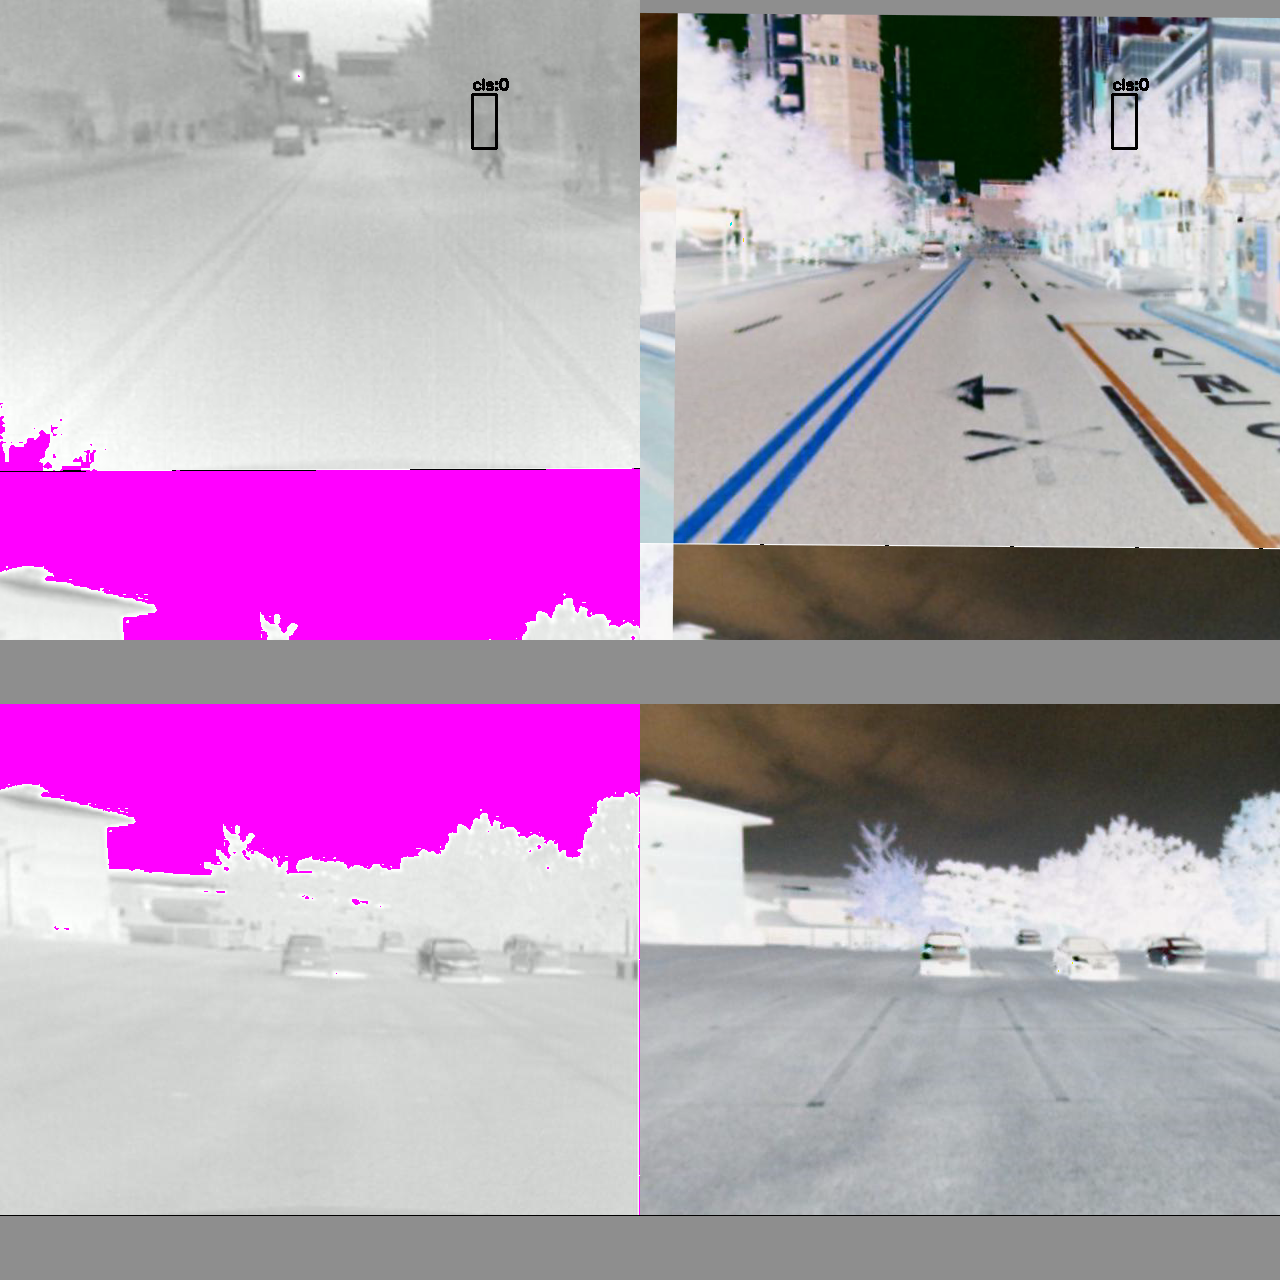

In [36]:
# 모자이크와 일반 이미지 함께 시각화
import cv2
import numpy as np
from PIL import Image
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy
import matplotlib.pyplot as plt
import copy

# 임의의 프레임 선택
ind = 1
frame = ind
ind += 1


# 원본 데이터셋 복사본 생성
dataset_orig = copy.deepcopy(dataset)
dataset_orig.mosaic = False  # 모자이크 비활성화
dataset_orig.augment = False  # 증강 비활성화

# 모자이크 증강이 적용된 데이터셋
dataset_mosaic = copy.deepcopy(dataset)
dataset_mosaic.mosaic = True  # 모자이크 증강 강제 적용

# 두 이미지 세트 로드
imgs_mosaic, targets_mosaic, paths_mosaic, shapes_mosaic, _ = LoadRGBTImagesAndLabels.collate_fn([dataset_mosaic[frame]])
imgs_orig, targets_orig, paths_orig, shapes_orig, _ = LoadRGBTImagesAndLabels.collate_fn([dataset_orig[frame]])

idx = 0

# 모자이크 증강된 이미지
img_lwir_mosaic = imgs_mosaic[0][idx].numpy().transpose((1, 2, 0))  # LWIR 이미지 (열화상)
img_vis_mosaic = imgs_mosaic[1][idx].numpy().transpose((1, 2, 0))   # RGB 이미지 (가시광선)

# 원본 이미지
img_lwir_orig = imgs_orig[0][idx].numpy().transpose((1, 2, 0))  # LWIR 이미지 (열화상)
img_vis_orig = imgs_orig[1][idx].numpy().transpose((1, 2, 0))   # RGB 이미지 (가시광선)

# --- 👇 디버깅 코드 추가 👇 ---
print("--- 이미지 데이터 검사 (img_vis_mosaic) ---")
print(f"Data Type: {img_vis_mosaic.dtype}")
print(f"Max Value: {img_vis_mosaic.max()}")
print(f"Min Value: {img_vis_mosaic.min()}")
print("------------------------------------")
# --- 디버깅 코드 끝 ---

# # 시각화를 위해 이미지 정규화 (0-255 범위로 변환)
# img_lwir_mosaic = np.clip(img_lwir_mosaic * 255, 0, 255).astype(np.uint8)
# img_vis_mosaic = np.clip(img_vis_mosaic * 255, 0, 255).astype(np.uint8)
# img_lwir_orig = np.clip(img_lwir_orig * 255, 0, 255).astype(np.uint8)
# img_vis_orig = np.clip(img_vis_orig * 255, 0, 255).astype(np.uint8)

# 이미지 형태 출력
print(f"Mosaic LWIR shape: {img_lwir_mosaic.shape}")
print(f"Mosaic VIS shape: {img_vis_mosaic.shape}")
print(f"Original LWIR shape: {img_lwir_orig.shape}")
print(f"Original VIS shape: {img_vis_orig.shape}")

# 바운딩 박스 시각화 함수
def draw_boxes(img, targets, idx, w, h):
    img_copy = img.copy()
    colors = {
        0: (255, 0, 0),    # 빨간색
        1: (0, 255, 0),    # 녹색
        2: (0, 0, 255),    # 파란색
        3: (255, 0, 255),  # 마젠타
    }
    
    # 현재 이미지에 해당하는 레이블만 필터링
    labels = targets.numpy()
    if len(labels):
        labels = labels[labels[:, 0] == idx, 1:]
        
        # 정규화된 바운딩 박스를 픽셀 좌표로 변환
        labels = np.array(labels, dtype=np.float32)
        labels[:, (1, 3)] *= w
        labels[:, (2, 4)] *= h
        
        cls = labels[:, 0]
        
        # xywh → xyxy 변환
        xyxy = xywh2xyxy(labels[:, 1:5])
        xyxy = xyxy.astype(np.int16)
        
        img_copy = np.ascontiguousarray(img_copy)
        
        # 이미지에 바운딩 박스 그리기
        for c, bb in zip(cls, xyxy):
            color = colors[int(c)]
            cv2.rectangle(img_copy, bb[:2], bb[2:], color, 2)
            cv2.putText(img_copy, f'cls:{int(c)}', (bb[0], bb[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_copy

# 바운딩 박스 그리기
h_mosaic, w_mosaic = img_vis_mosaic.shape[:2]
h_orig, w_orig = img_vis_orig.shape[:2]

img_lwir_mosaic_box = draw_boxes(img_lwir_mosaic, targets_mosaic, idx, w_mosaic, h_mosaic)
img_vis_mosaic_box = draw_boxes(img_vis_mosaic, targets_mosaic, idx, w_mosaic, h_mosaic)
img_lwir_orig_box = draw_boxes(img_lwir_orig, targets_orig, idx, w_orig, h_orig)
img_vis_orig_box = draw_boxes(img_vis_orig, targets_orig, idx, w_orig, h_orig)

img_lwir_mosaic_box = img_lwir_mosaic_box.astype(np.uint8)
img_vis_mosaic_box = img_vis_mosaic_box.astype(np.uint8)
img_lwir_orig_box = img_lwir_orig_box.astype(np.uint8)
img_vis_orig_box = img_vis_orig_box.astype(np.uint8)

# 이미지 시각화
plt.figure(figsize=(16, 12))

# 모자이크 이미지 표시
plt.subplot(2, 2, 1)
plt.title("Mosaic LWIR (Thermal)")
plt.imshow(img_lwir_mosaic_box)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Mosaic VIS (RGB)")
plt.imshow(img_vis_mosaic_box)
plt.axis('off')

# 원본 이미지 표시
plt.subplot(2, 2, 3)
plt.title("Original LWIR (Thermal)")
plt.imshow(img_lwir_orig_box)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Original VIS (RGB)")
plt.imshow(img_vis_orig_box)
plt.axis('off')

plt.suptitle("Mosaic Augmentation vs Original Images")
plt.tight_layout()
plt.show()

# 경로 출력
print(f"Mosaic path: {paths_mosaic[idx]}")
print(f"Original path: {paths_orig[idx]}")

# 모자이크와 원본 이미지 병합 (시각적 비교)
mosaic_images = np.concatenate([img_lwir_mosaic_box, img_vis_mosaic_box], axis=1)
orig_images = np.concatenate([img_lwir_orig_box, img_vis_orig_box], axis=1)
final_comparison = np.vstack([mosaic_images, orig_images])

# Image.fromarray(final_comparison)
final_comparison_for_display = np.clip(final_comparison * 255, 0, 255).astype(np.uint8)

# 변환된 이미지로 PIL Image 객체 생성
Image.fromarray(final_comparison_for_display)

In [39]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

# frame = 12112
frame = 5888

# Get a minibatch
# for ii, (imgs, targets, paths, _) in enumerate(train_loader):
#     break

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

print(img_lwir.shape)
print(img_vis.shape)
images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)

(640, 640, 3)
(640, 640, 3)
datasets/kaist-rgbt/train/images/{}/set01_V003_I01259.jpg


TypeError: Cannot handle this data type: (1, 1, 3), <f8

## Run trained model
- Visualize bounding boxes from dataset class

In [54]:
import torch
from models.yolo import Model
from utils.torch_utils import select_device

weights = 'kaist-rgbt_best.pt'      # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 1
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward
    # print(pred)

YOLOv5 🚀 bddaf3c Python-3.10.16 torch-2.7.0+cu126 CPU


                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1     37632  models.common.MultiStreamC3             [64, 64, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
  5                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
  6                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3

In [ ]:
from utils.general import scale_boxes, non_max_suppression

conf_thres = 0.05  # confidence threshold
iou_thres = 0.05  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS
# print(pred)

nms_pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
print(nms_pred)

# Resize predicted box
# scale_boxes(imgs.shape[2:], pred.xyxy[0], shapes[0])         # see valpy:L285

# [TODO] draw predictions (see detect.py:L178)


[tensor([], size=(0, 6))]


In [27]:
pred[0]

tensor([], size=(0, 6))